In [1]:
# Python version -> 3.8.12
### For GPU set up:
#Install the Tensorflow dependencies:    conda install -c apple tensorflow-deps
#Install base Tensorflow:     pip install tensorflow-macos
#Install metal plugin:   pip install tensorflow-metal


### Install Packages
#conda install pandas
#conda install scikit-learn
#conda install matplotlib
#pip install pyyaml h5py 

#pip install matplotlib
#conda install scikit-learn librosa



### Import libraries
import sys
import tensorflow
import pandas as pd
import sklearn as sk
import tensorflow as tf
import os
import IPython as IP
import struct
import matplotlib.pyplot as plt
import numpy as np
import h5py
#import librosa
#import librosa.display
import math
import pickle

import random
from datetime import datetime

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint 
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")
print(len(tf.config.list_physical_devices('GPU')))

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
Pandas 1.3.4
Scikit-Learn 1.0.1
GPU is available
1


In [2]:
### Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('data/UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

In [14]:
# Pre-processed MFCC coefficients
X = np.load("data/X-mfcc.npy")
y = np.load("data/y-mfcc.npy")

# Metadata
metadata = pd.read_csv(metadata_path)

In [15]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 1746 		 Train split: 6986
X test shape: (1746, 40, 174) 	 X train shape: (6986, 40, 174)
y test shape: (1746,) 		 y train shape: (6986,)


In [16]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [17]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

In [18]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [19]:
#adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
adam = Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

In [20]:
num_epochs = 250
num_batch_size = 128
model_file = 'simple-train-nb3-mfcc.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250


2021-11-01 14:46:28.621864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - ETA: 0s - loss: 2.1742 - accuracy: 0.2236

2021-11-01 14:46:38.596990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


51/51 [==============================] - 11s 199ms/step - loss: 2.1742 - accuracy: 0.2236 - val_loss: 2.3903 - val_accuracy: 0.1029

Epoch 00001: val_loss improved from inf to 2.39027, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 2/250
51/51 [==============================] - 10s 191ms/step - loss: 1.9278 - accuracy: 0.3420 - val_loss: 2.4493 - val_accuracy: 0.1115

Epoch 00002: val_loss did not improve from 2.39027
Epoch 3/250
51/51 [==============================] - 10s 189ms/step - loss: 1.8208 - accuracy: 0.3751 - val_loss: 2.5934 - val_accuracy: 0.1870

Epoch 00003: val_loss did not improve from 2.39027
Epoch 4/250
51/51 [==============================] - 10s 190ms/step - loss: 1.7480 - accuracy: 0.4068 - val_loss: 2.7532 - val_accuracy: 0.1887

Epoch 00004: val_loss did not improve from 2.39027
Epoch 5/250
51/51 [==============================] - 10s 189ms/step - loss: 1.6932 - accuracy: 0.4243 - val_loss: 2.8311 - val_acc

51/51 [==============================] - 10s 191ms/step - loss: 0.9939 - accuracy: 0.7023 - val_loss: 0.8724 - val_accuracy: 0.7530

Epoch 00061: val_loss improved from 0.87989 to 0.87242, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 62/250
51/51 [==============================] - 10s 192ms/step - loss: 0.9945 - accuracy: 0.7012 - val_loss: 0.8669 - val_accuracy: 0.7496

Epoch 00062: val_loss improved from 0.87242 to 0.86691, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 63/250
51/51 [==============================] - 10s 192ms/step - loss: 0.9928 - accuracy: 0.6947 - val_loss: 0.8821 - val_accuracy: 0.7547

Epoch 00063: val_loss did not improve from 0.86691
Epoch 64/250
51/51 [==============================] - 10s 193ms/step - loss: 0.9906 - accuracy: 0.6970 - val_loss: 0.8758 - val_accuracy: 0.7581

Epoch 00064: val_loss did not improve from 0.86691
Epoch 65/250
51/51 [=


Epoch 00124: val_loss improved from 0.65547 to 0.65516, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 125/250
51/51 [==============================] - 10s 189ms/step - loss: 0.7627 - accuracy: 0.7796 - val_loss: 0.6535 - val_accuracy: 0.8182

Epoch 00125: val_loss improved from 0.65516 to 0.65354, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 126/250
51/51 [==============================] - 10s 189ms/step - loss: 0.7635 - accuracy: 0.7754 - val_loss: 0.6493 - val_accuracy: 0.8130

Epoch 00126: val_loss improved from 0.65354 to 0.64932, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 127/250
51/51 [==============================] - 10s 189ms/step - loss: 0.7608 - accuracy: 0.7764 - val_loss: 0.6389 - val_accuracy: 0.8233

Epoch 00127: val_loss improved from 0.64932 to 0.63892, saving model to /Users/manjuvallayil/minifo

51/51 [==============================] - 10s 189ms/step - loss: 0.6870 - accuracy: 0.8017 - val_loss: 0.5882 - val_accuracy: 0.8353

Epoch 00158: val_loss did not improve from 0.58594
Epoch 159/250
51/51 [==============================] - 10s 190ms/step - loss: 0.6902 - accuracy: 0.7998 - val_loss: 0.5776 - val_accuracy: 0.8405

Epoch 00159: val_loss improved from 0.58594 to 0.57759, saving model to /Users/manjuvallayil/miniforge3/envs/TeReo-gpu/models/simple-train-nb3-mfcc.hdf5
Epoch 160/250
51/51 [==============================] - 361s 7s/step - loss: 0.6938 - accuracy: 0.8001 - val_loss: 0.5820 - val_accuracy: 0.8439

Epoch 00160: val_loss did not improve from 0.57759
Epoch 161/250
51/51 [==============================] - 10s 193ms/step - loss: 0.6880 - accuracy: 0.8031 - val_loss: 0.5874 - val_accuracy: 0.8353

Epoch 00161: val_loss did not improve from 0.57759
Epoch 162/250
51/51 [==============================] - 10s 189ms/step - loss: 0.6952 - accuracy: 0.7984 - val_loss: 0.5761

51/51 [==============================] - 2027s 41s/step - loss: 0.5664 - accuracy: 0.8404 - val_loss: 0.4815 - val_accuracy: 0.8765

Epoch 00229: val_loss did not improve from 0.47777
Epoch 230/250
51/51 [==============================] - 2071s 41s/step - loss: 0.5746 - accuracy: 0.8351 - val_loss: 0.4801 - val_accuracy: 0.8799

Epoch 00230: val_loss did not improve from 0.47777
Epoch 231/250
51/51 [==============================] - 351s 7s/step - loss: 0.5790 - accuracy: 0.8388 - val_loss: 0.4793 - val_accuracy: 0.8714

Epoch 00231: val_loss did not improve from 0.47777
Epoch 232/250
51/51 [==============================] - 10s 195ms/step - loss: 0.5668 - accuracy: 0.8388 - val_loss: 0.4887 - val_accuracy: 0.8559

Epoch 00232: val_loss did not improve from 0.47777
Epoch 233/250
51/51 [==============================] - 10s 191ms/step - loss: 0.5611 - accuracy: 0.8426 - val_loss: 0.4946 - val_accuracy: 0.8679

Epoch 00233: val_loss did not improve from 0.47777
Epoch 234/250
51/51 [=====

In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38

    # Compute scores
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)

    # Pint Train vs Test report
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))


    # Calculate and report normalized error difference?
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

# Load best saved model
model = load_model(model_path)
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

2021-11-01 20:14:15.045906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


                    LOSS      ACCURACY
--------------------------------------
Training:         0.4352       89.5076
Test:             0.4614       88.0871
Normal diff          5.68 


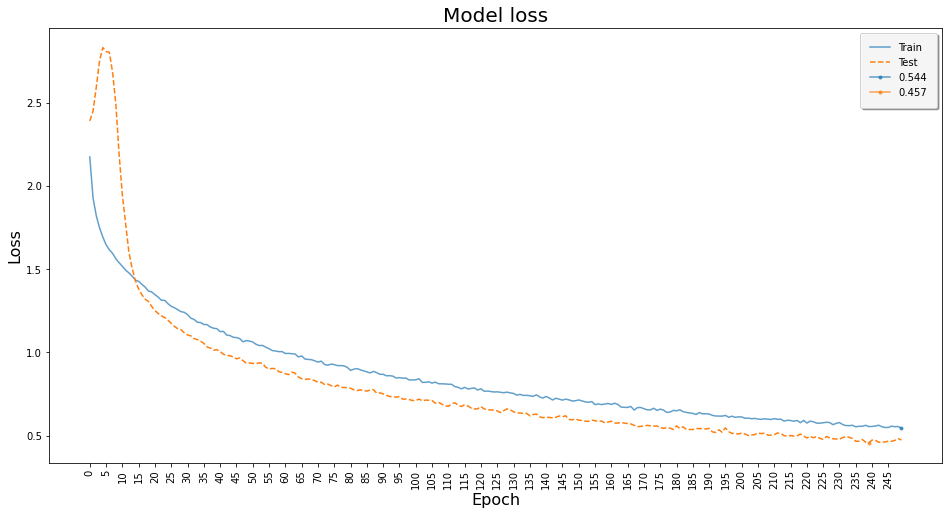

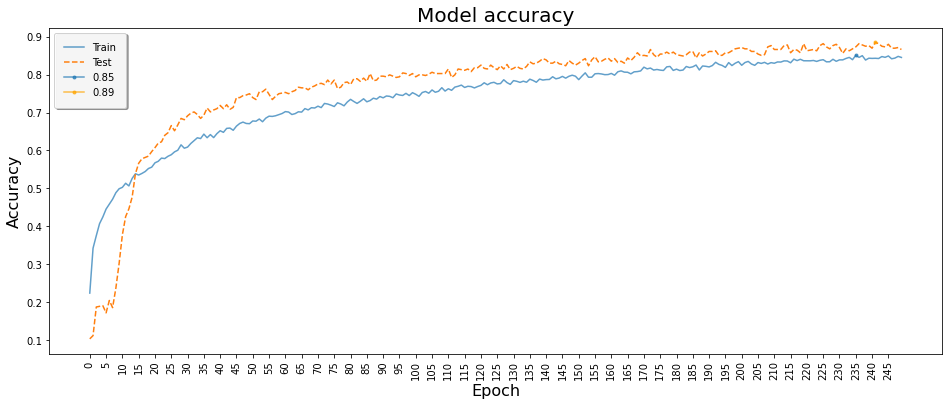

In [33]:
def plot_train_history(history, x_ticks_vertical=False):
    history = history.history

    # min loss / max accs
    min_loss = min(history['loss'])
    min_val_loss = min(history['val_loss'])
    max_accuracy = max(history['accuracy'])
    max_val_accuracy = max(history['val_accuracy'])

    # x pos for loss / acc min/max
    min_loss_x = history['loss'].index(min_loss)
    min_val_loss_x = history['val_loss'].index(min_val_loss)
    max_accuracy_x = history['accuracy'].index(max_accuracy)
    max_val_accuracy_x = history['val_accuracy'].index(max_val_accuracy)

    # summarize history for loss, display min
    plt.figure(figsize=(16,8))
    plt.plot(history['loss'], color="#1f77b4", alpha=0.7)
    plt.plot(history['val_loss'], color="#ff7f0e", linestyle="--")
    plt.plot(min_loss_x, min_loss, marker='o', markersize=3, color="#1f77b4", alpha=0.7, label='Inline label')
    plt.plot(min_val_loss_x, min_val_loss, marker='o', markersize=3, color="#ff7f0e", alpha=0.7, label='Inline label')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 
                'Test', 
                ('%.3f' % min_loss), 
                ('%.3f' % min_val_loss)], 
                loc='upper right', 
                fancybox=True, 
                framealpha=0.9, 
                shadow=True, 
                borderpad=1)
    if (x_ticks_vertical):
        plt.xticks(np.arange(0, len(history['loss']), 5.0), rotation='vertical')
    else:
        plt.xticks(np.arange(0, len(history['loss']), 5.0))

    plt.show()

    # summarize history for accuracy, display max
    plt.figure(figsize=(16,6))
    plt.plot(history['accuracy'], alpha=0.7)
    plt.plot(history['val_accuracy'], linestyle="--")
    plt.plot(max_accuracy_x, max_accuracy, marker='o', markersize=3, color="#1f77b4", alpha=0.7)
    plt.plot(max_val_accuracy_x, max_val_accuracy, marker='o', markersize=3, color="orange", alpha=0.7)
    plt.title('Model accuracy', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 
                'Test', 
                ('%.2f' % max_accuracy), 
                ('%.2f' % max_val_accuracy)], 
                loc='upper left', 
                fancybox=True, 
                framealpha=0.9, 
                shadow=True, 
                borderpad=1)
    plt.figure(num=1, figsize=(10, 6))

    if (x_ticks_vertical):
        plt.xticks(np.arange(0, len(history['accuracy']), 5.0), rotation='vertical')
    else:
        plt.xticks(np.arange(0, len(history['accuracy']), 5.0))

    plt.show()
    


plot_train_history(history, x_ticks_vertical=True)


In [24]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

2021-11-01 21:24:58.610136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
/var/folders/ts/975gflv16y9_wd421n6z6w8c0000gn/T/ipykernel_11697/1987032789.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['pred'] = yhat_probs


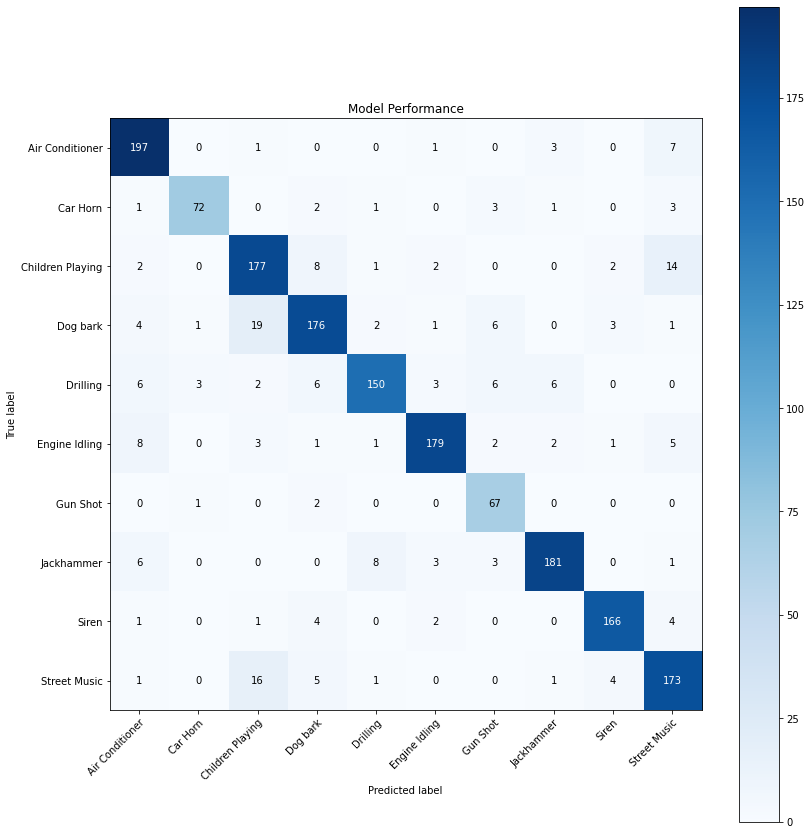

In [25]:
# Plots a confussion matrix
def plot_confusion_matrix(cm,
                          classes, 
                          normalized=False, 
                          title=None, 
                          cmap=plt.cm.Blues,
                          size=(10,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalized else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)


# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

In [26]:
# Expects a NumPy array with probabilities and a confusion matrix data, retuns accuracy per class
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

# Find per-class accuracy from the confusion matrix data
accuracies = acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,95.714286
0,Air Conditioner,94.258373
8,Siren,93.258427
7,Jackhammer,89.603960
5,Engine Idling,88.613861
1,Car Horn,86.746988
9,Street Music,86.069652
2,Children Playing,85.922330
3,Dog bark,82.629108
4,Drilling,82.417582


In [28]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.87      0.94      0.91       209
        Car Horn       0.94      0.87      0.90        83
Children Playing       0.81      0.86      0.83       206
        Dog bark       0.86      0.83      0.84       213
        Drilling       0.91      0.82      0.87       182
   Engine Idling       0.94      0.89      0.91       202
        Gun Shot       0.77      0.96      0.85        70
      Jackhammer       0.93      0.90      0.91       202
           Siren       0.94      0.93      0.94       178
    Street Music       0.83      0.86      0.85       201

        accuracy                           0.88      1746
       macro avg       0.88      0.89      0.88      1746
    weighted avg       0.88      0.88      0.88      1746

